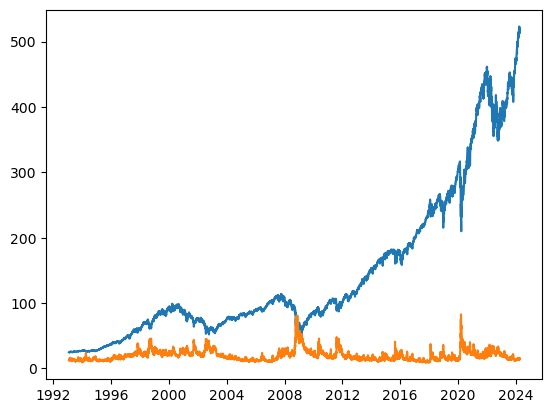

In [2]:
##Imports
import yfinance as yf
import numpy as np
import pandas as pd
import scipy as sc
from scipy import optimize
from scipy.stats import norm
import pandas_ta as ta

import matplotlib.pyplot as plt
%matplotlib inline

spy=yf.Ticker('SPY').history('max')
spy=spy.reset_index()
start=spy['Date'].iloc[0]
end=spy['Date'].iloc[-1]

vix=yf.Ticker('^VIX').history(start=start, end= end)

spy=spy.set_index('Date')

plt.plot(spy['Close'])
plt.plot(vix['Close'])
plt.show()

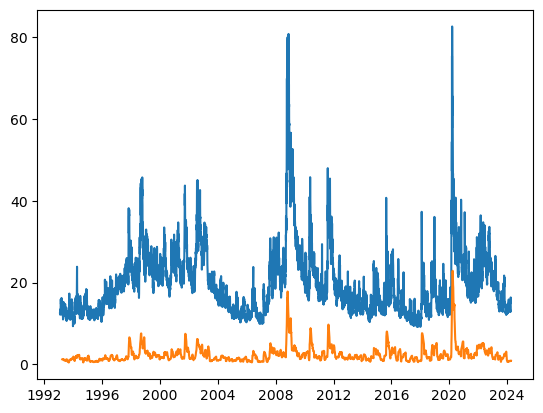

In [3]:
#vix_arr=np.array(vix['Close'])
x=np.array(vix['Close'].iloc[-252:-1])

N =x.size
    
Xx  = np.sum(x[0:-1])
Xy  = np.sum(x[1:])
Xxx = np.sum(x[0:-1]**2)
Xxy = np.sum(x[0:-1] * x[1:])
Xyy = np.sum(x[1:]**2)
#N=len(vix_arr[1:])
#Xx=np.sum(vix_arr[1:-1])
#Xy=np.sum(vix_arr[1:])
#Xxx=np.sum((vix_arr[1:-1])**2)
#Xxy=np.sum(vix_arr[0:-1] * vix_arr[1:])
#Xyy=np.sum(vix_arr[1:]**2)

#theta0=(Xy*Xxx-Xx*Xxy)/ \
#    (N*(Xxx-Xxy)-(Xx**2-Xx*Xy))

dt=1/252
theta0 = (Xy * Xxx - Xx * Xxy) / (N * (Xxx - Xxy) - (Xx**2 - Xx * Xy) )
mu0= (Xxy - theta0 * Xx - theta0 * Xy + N * theta0**2) / \
        (Xxx - 2 * theta0 * Xx + N * theta0**2)
mu0 = -1 / dt * np.log(mu0)

prefactor = 2 * mu0 / (N*(1-np.exp(-2*mu0*dt)))
term = Xyy - 2*np.exp(-mu0*dt) * Xxy + np.exp(-2*mu0*dt) * Xxx - 2*theta0*(1-np.exp(-mu0*dt)) * (Xy - Xx * np.exp(-mu0*dt)) + N * theta0**2 * ( 1-np.exp(-mu0 * dt))**2
sigma02 = prefactor * term
sigma0 = np.sqrt(sigma02)


plt.plot(vix['Close'])
plt.plot(vix['Close'].rolling(40).std())

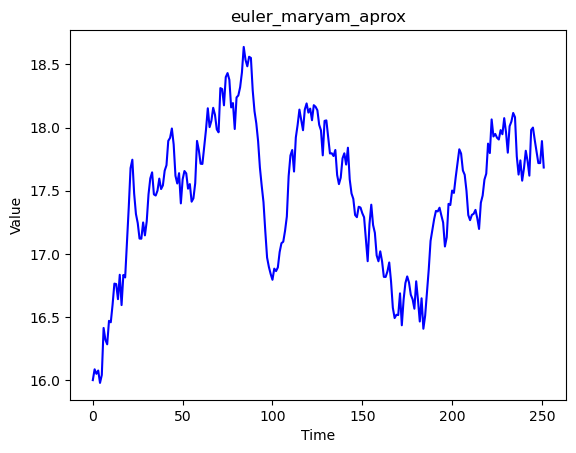

In [5]:
# discrete ornstein_uhlenbeck


def euler_maryam_aprox(k,mu,t_step,sigma,forecast, t0):
    #cast:
    aprox=np.zeros(forecast)
    aprox[0]=t0
    #loop
    for i in range(1,forecast):
        aprox[i]= \
        k*(mu-aprox[i-1])*t_step+sigma*np.sqrt(t_step)*np.random.normal()+aprox[i-1]
        
    return aprox




plt.plot(
    euler_maryam_aprox(
    k=theta0,
    mu=mu0,
    t_step=1/252,
    sigma=np.std(x),
    forecast=252,
    t0=16   #vix['Close'].iloc[-1]
    ),
    'b-'
)

vix['Close'].mean()
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('euler_maryam_aprox')
plt.show()

In [6]:
print("sigma:",sigma0,'Std:',np.std(x))

sigma: 13.370814182624198 Std: 2.1437439771878126


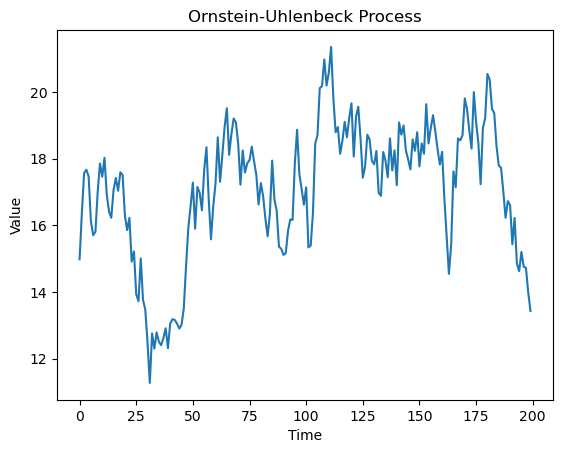

In [7]:
def ornstein_uhlenbeck(x0, theta, mu, sigma, dt, n_steps):
    x = np.zeros(n_steps)
    x[0] = x0

    for t in range(1, n_steps):
        x[t] = x[t-1] + theta * (mu - x[t-1]) * dt + sigma * np.sqrt(dt) * np.random.normal()

    return x

x0 = vix['Close'].iloc[-1]
theta = theta0
mu = mu0
sigma = sigma0
dt = 1/252
n_steps = 200


plt.plot(ornstein_uhlenbeck(x0, theta, mu, sigma, dt, n_steps))
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Ornstein-Uhlenbeck Process')
plt.show()

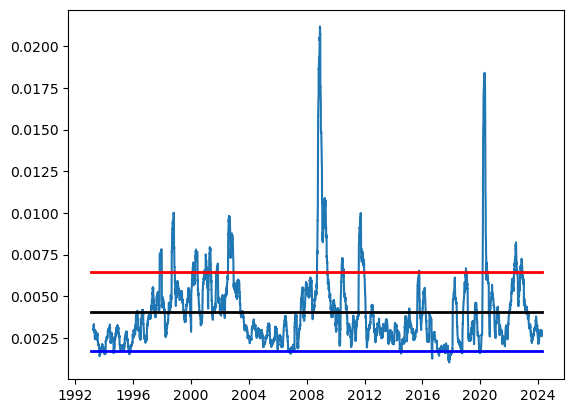

In [8]:
window=40
spy['returnsL']=np.log(spy['Close']/spy['Close'].shift(1))


spy['RealVol']=spy['returnsL'].rolling(window).std()*np.sqrt(window/252)
std=spy['RealVol'].std()
buy=spy['RealVol'].mean()+std
sell=spy['RealVol'].mean()-std
mean=spy['RealVol'].mean()
plt.plot(spy['RealVol'])
plt.plot([spy.index[0] , spy.index[-1]], [buy,buy], 'r', lw=2)
plt.plot([spy.index[0] , spy.index[-1]], [sell,sell], 'b', lw=2)
plt.plot([spy.index[0] , spy.index[-1]], [mean,mean], 'k', lw=2)

spy['RealVolChange']=np.log(abs(spy['RealVol'].diff()))

<StemContainer object of 3 artists>

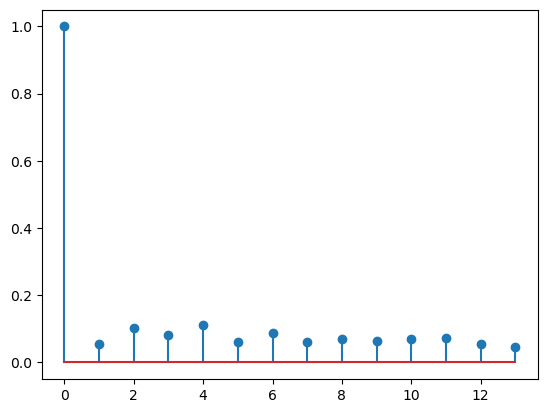

In [9]:
spy=spy.dropna()
RealVol=np.array(spy['RealVolChange'])
lags=np.arange(0,14)

#lagging 
autocor=[]


for lag in lags:
    
    lags_arr=np.zeros(RealVol.size)
    
    for i in range(lags_arr.size):
        lags_arr[i]=RealVol[i-lag]
    
    X=lags_arr
    N=X.size
    Y=RealVol[:N]

    autocor.append(
        np.corrcoef(X,Y)[0][1]
    )
    

plt.stem(autocor)

-0.9281455158583125


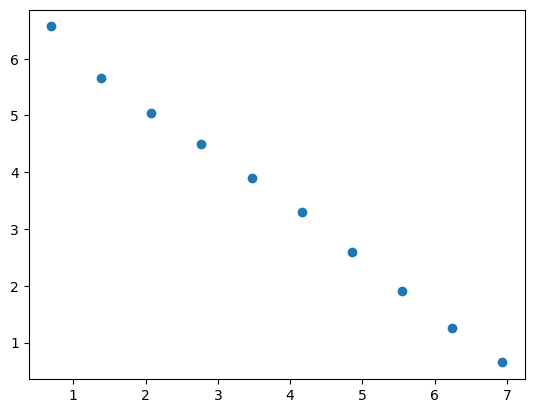

In [10]:
datapoints=2**12
RealVol=np.array(spy['RealVol'])
X=[]
Y=[]


for q in np.arange(1,np.log2(datapoints)-1):
    
    samples = 2**q
    R=[]
    

    for i in range(1,int(samples)+1):
        start=int((i-1)*datapoints/samples)
        stop=int(i*datapoints/samples+1)
        arr=RealVol[start:stop]
        mu=np.mean(arr)
        std=np.std(arr)
        arr=[arr[x]-mu  for x in range(1,len(arr))]
        
        
        
        cumdev = [sum(arr[:x]) for x in range(1,len(arr)+1)]
        R.append(np.log(((np.max(cumdev))-(np.min(cumdev)))/std))
        
        
    X.append(np.log(samples))
    Y.append(np.mean(R))

    
plt.scatter(X,Y)
print(np.polyfit(X,Y,1)[0])

In [17]:
#hypothesis: 
#Vixin volatiliteetti ei ole vakio, 
#joten kirjoitetaan ML-malli aproxomoimaan Ohrstein-Uhlenbeckin parametreja.

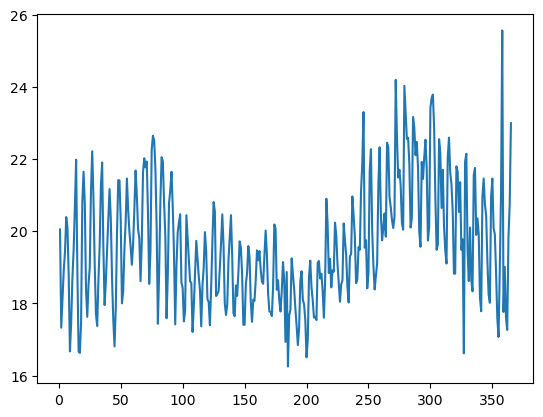

In [11]:
#avg timely volatility
daydict={}
avg_daily=[]


for date in range(1,max(vix['Close'].index.dayofyear+1)):
    a=np.mean(vix['Close'].iloc[np.where(
        vix['Close'].index.dayofyear==date)]
           )
    daydict[str(date)]=a


    
for date in vix['Close'].index.dayofyear:
    avg_daily.append(daydict[str(date)])


avg_daily_cycle=[]



for date in range(1,len(daydict)+1):
    avg_daily_cycle.append(daydict[str(date)])
    
    
plt.plot(avg_daily_cycle)

looginen päätelmä: Volatiliteetti käy syklistä vaihtelua sznin mukaan.

tätä perutelee se, että datasetin ollessa tarpeeksi iso (20 vuotta)

"Random Walk"- liikkeen keskiarvo pitäisi pysyä samana.

täten sovitetaan dataan fourierin sarja.

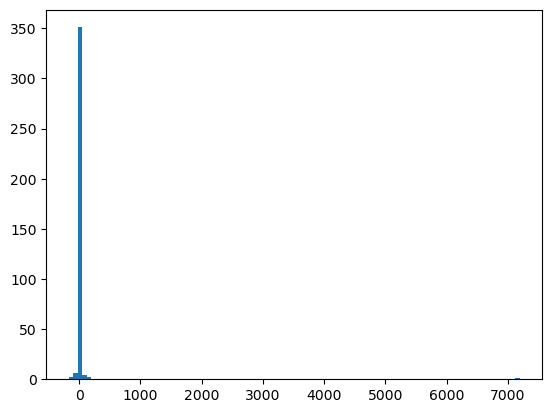

In [20]:
avg_daily_cycle[0]=avg_daily_cycle[-1]
ft=sc.fft.fft(avg_daily_cycle)
plt.hist(np.real(ft),100)
plt.show()

[0.12207283 2.00433069]


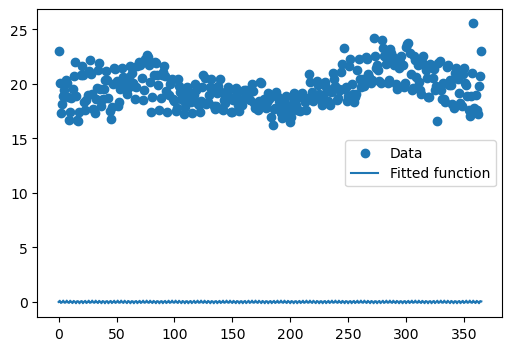

In [33]:
def test_func(x, a, b):
    return a * np.sin(b * x)

params, params_covariance = optimize.curve_fit(test_func, range(len(avg_daily_cycle)) , avg_daily_cycle,
                                               p0=[2, 2])

print(params)

plt.figure(figsize=(6, 4))
plt.scatter(range(len(avg_daily_cycle)),avg_daily_cycle, label='Data')
plt.plot(range(len(avg_daily_cycle)), test_func(range(len(avg_daily_cycle)), params[0], params[1]),
         label='Fitted function')

plt.legend(loc='best')


In [47]:
cs=sc.interpolate.CubicSpline(range(len(avg_daily_cycle)) , avg_daily_cycle)
X=np.arange(len(avg_daily_cycle))
plt.plot(X , cs(X,avg_daily_cycle))


TypeError: an integer is required